### Forecasting using neural networks (LSTM)

We will start with LSTM, because:

+ Transformers are not preferred, because:

    + We are limited in terms of gpu resources

    + Data is not that complex, so there is no need to use too advanced architectures

    + There amount of data might not be sufficient to train a transformer model

+ We want to use the neural network architectures that deal with the sequential data

+ RNNs might be too simple for this task, as they are usually not that good in capturing long-term dependencies

+ LSTM is a good compromise between the complexity of the model and the ability to capture long-term dependencies

**We will train the model from scratch**

+ We want to do forecasting for 96 and 192 steps ahead.

+ Suppose we want to forecast the next 96 steps. This can be done in two different ways: we either train the model to predict next 96 steps immediately, or train it to predict another number of steps. For example, we can train it to predict next 48 steps, and then use the predicted values as input to predict the next 48 steps. Although this approach might be more efficient, we will use the first one for simplicity. Note that our main goal is to compare different forecasting methods, rather than optimizing the model for the best performance

### In this notebook, we will use the simple version of the LSTM pipeline:

+ Use LSTM to get the hidden representation of the time series data

+ Feed this hidden representation into a fully connected layer to get the forecast

+ The linear layer will output the number of observations equal to the number of forecast steps

+ We will use 1 LSTM layer, and we will experiment with several sizes of the hidden state

+ SEQ_LENGTH (the number of observations we look back on) will be fixed, and it will be equal to 96

+ The number of forecast steps will be equal to 96 or 192, and we will train the model on all of the datasets (ETTh1, ETTh2, ETTm1, ETTm2)

+ We will use MAE as the loss function

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
from split_data import split_dataframe
from normalisation import standardize_data
df_h1 = pd.read_csv('ETT-small/ETTh1.csv')
df_h1['date'] = pd.to_datetime(df_h1['date'])
df_h2 = pd.read_csv('ETT-small/ETTh2.csv')
df_h2['date'] = pd.to_datetime(df_h2['date'])
df_m1 = pd.read_csv('ETT-small/ETTm1.csv')
df_m1['date'] = pd.to_datetime(df_m1['date'])
df_m2 = pd.read_csv('ETT-small/ETTm2.csv')
df_m2['date'] = pd.to_datetime(df_m2['date'])
train_h1, val_h1, test_h1 = split_dataframe(df_h1)
train_h1, val_h1, test_h1 = standardize_data(train_h1, val_h1, test_h1)
train_h2, val_h2, test_h2 = split_dataframe(df_h2)
train_h2, val_h2, test_h2 = standardize_data(train_h2, val_h2, test_h2)
train_m1, val_m1, test_m1 = split_dataframe(df_m1)
train_m1, val_m1, test_m1 = standardize_data(train_m1, val_m1, test_m1)
train_m2, val_m2, test_m2 = split_dataframe(df_m2)
train_m2, val_m2, test_m2 = standardize_data(train_m2, val_m2, test_m2)

In [3]:
from lstm import TimeSeriesDataset, LSTMForecaster, train_lstm, evaluate_lstm, evaluate_single_forecast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [4]:
features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

In [5]:
SEQ_LENGTH = 96       # Input window size
FORECAST_STEPS = 96   # Number of steps to predict
BATCH_SIZE = 128
def create_dataloaders(train, val, test, SEQ_LENGTH=SEQ_LENGTH, FORECAST_STEPS=FORECAST_STEPS):
    train_data = train[features].values
    val_data = val[features].values
    test_data = test[features].values
    train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH, FORECAST_STEPS)
    val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH, FORECAST_STEPS)
    test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH, FORECAST_STEPS)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda:1


### Train LSTM on h1

**Choose the optimal hidden size by trying different ones**

Epoch 1/50
Train Loss: 0.7755 | Val Loss: 1.2175
Epoch 2/50
Train Loss: 0.7118 | Val Loss: 1.0719
Epoch 3/50
Train Loss: 0.5420 | Val Loss: 0.7541
Epoch 4/50
Train Loss: 0.4301 | Val Loss: 0.6812
Epoch 5/50
Train Loss: 0.3707 | Val Loss: 0.6416
Epoch 6/50
Train Loss: 0.3468 | Val Loss: 0.6350
Epoch 7/50
Train Loss: 0.3368 | Val Loss: 0.6207
Epoch 8/50
Train Loss: 0.3316 | Val Loss: 0.6462
Epoch 9/50
Train Loss: 0.3285 | Val Loss: 0.6271
Epoch 10/50
Train Loss: 0.3266 | Val Loss: 0.6413
Epoch 11/50
Train Loss: 0.3250 | Val Loss: 0.6257
Epoch 12/50
Train Loss: 0.3234 | Val Loss: 0.6272
Epoch 13/50
Train Loss: 0.3219 | Val Loss: 0.6462
Epoch 14/50
Train Loss: 0.3204 | Val Loss: 0.6458
Epoch 15/50
Train Loss: 0.3190 | Val Loss: 0.6590
Epoch 16/50
Train Loss: 0.3175 | Val Loss: 0.6705
Epoch 17/50
Train Loss: 0.3162 | Val Loss: 0.6570
Early stopping after 17 epochs
Mean Squared Error (MSE): 0.9916
Mean Absolute Error (MAE): 0.9842


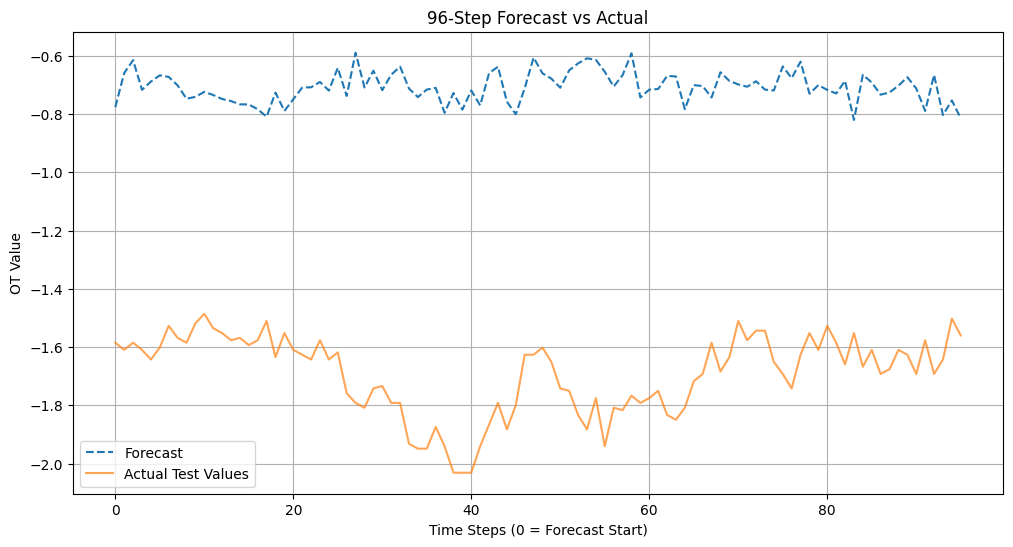

In [ ]:
SEQ_LENGTH = 96       # Input window size
FORECAST_STEPS = 96   # Number of steps to predict
HIDDEN_SIZE = 64
NUM_LAYERS = 1
LEARNING_RATE = 0.0001
N_EPOCHS = 50
N_EARLY_STOP = 10
train_loader_h1, val_loader_h1, test_loader_h1 = create_dataloaders(train_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS)
model_h1 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h1, train_loader_h1, val_loader_h1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=10, save_path="lstm_weights/exp.pth", criterion=nn.L1Loss())
mse_h1_96_lstm, mae_h1_96_lstm = evaluate_single_forecast(model_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=False, plot_filename="results_images/lstm_h1_96.png")

Epoch 1/50
Train Loss: 0.6922 | Val Loss: 0.8117
Epoch 2/50
Train Loss: 0.3775 | Val Loss: 0.6062
Epoch 3/50
Train Loss: 0.3328 | Val Loss: 0.5837
Epoch 4/50
Train Loss: 0.3284 | Val Loss: 0.5500
Epoch 5/50
Train Loss: 0.3258 | Val Loss: 0.5764
Epoch 6/50
Train Loss: 0.3240 | Val Loss: 0.5729
Epoch 7/50
Train Loss: 0.3216 | Val Loss: 0.6123
Epoch 8/50
Train Loss: 0.3210 | Val Loss: 0.5901
Epoch 9/50
Train Loss: 0.3202 | Val Loss: 0.5758
Epoch 10/50
Train Loss: 0.3172 | Val Loss: 0.5796
Epoch 11/50
Train Loss: 0.3147 | Val Loss: 0.5745
Epoch 12/50
Train Loss: 0.3119 | Val Loss: 0.6179
Epoch 13/50
Train Loss: 0.3099 | Val Loss: 0.5583
Epoch 14/50
Train Loss: 0.3081 | Val Loss: 0.5868
Early stopping after 14 epochs
Mean Squared Error (MSE): 0.5748
Mean Absolute Error (MAE): 0.7414


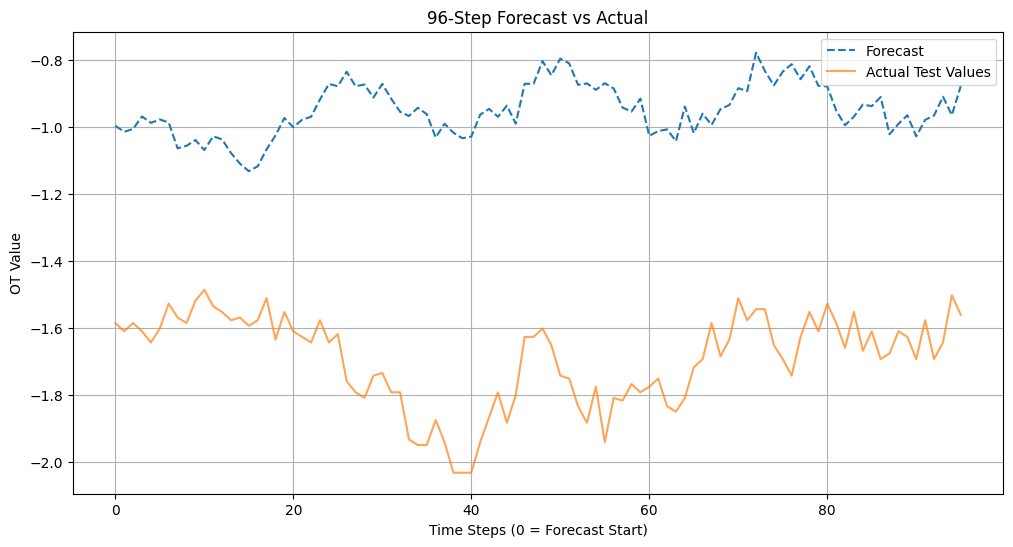

In [ ]:
# change hidden size from 64 to 256
# 256 seems to be better
SEQ_LENGTH = 96       # Input window size
FORECAST_STEPS = 96   # Number of steps to predict
HIDDEN_SIZE = 256
NUM_LAYERS = 1
LEARNING_RATE = 0.0001
N_EPOCHS = 50
N_EARLY_STOP = 10
train_loader_h1, val_loader_h1, test_loader_h1 = create_dataloaders(train_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS)
model_h1 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h1, train_loader_h1, val_loader_h1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=10, save_path="lstm_weights/exp.pth", criterion=nn.L1Loss())
mse_h1_96_lstm, mae_h1_96_lstm = evaluate_single_forecast(model_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=False, plot_filename="results_images/lstm_h1_96.png")

Epoch 1/50
Train Loss: 0.5942 | Val Loss: 0.8412
Epoch 2/50
Train Loss: 0.3487 | Val Loss: 0.5895
Epoch 3/50
Train Loss: 0.3304 | Val Loss: 0.4879
Epoch 4/50
Train Loss: 0.3274 | Val Loss: 0.6053
Epoch 5/50
Train Loss: 0.3256 | Val Loss: 0.5320
Epoch 6/50
Train Loss: 0.3229 | Val Loss: 0.5380
Epoch 7/50
Train Loss: 0.3200 | Val Loss: 0.5804
Epoch 8/50
Train Loss: 0.3162 | Val Loss: 0.5660
Epoch 9/50
Train Loss: 0.3142 | Val Loss: 0.5511
Epoch 10/50
Train Loss: 0.3124 | Val Loss: 0.5314
Epoch 11/50
Train Loss: 0.3077 | Val Loss: 0.5963
Epoch 12/50
Train Loss: 0.3054 | Val Loss: 0.5113
Epoch 13/50
Train Loss: 0.3011 | Val Loss: 0.5260
Early stopping after 13 epochs
Mean Squared Error (MSE): 0.5764
Mean Absolute Error (MAE): 0.7345


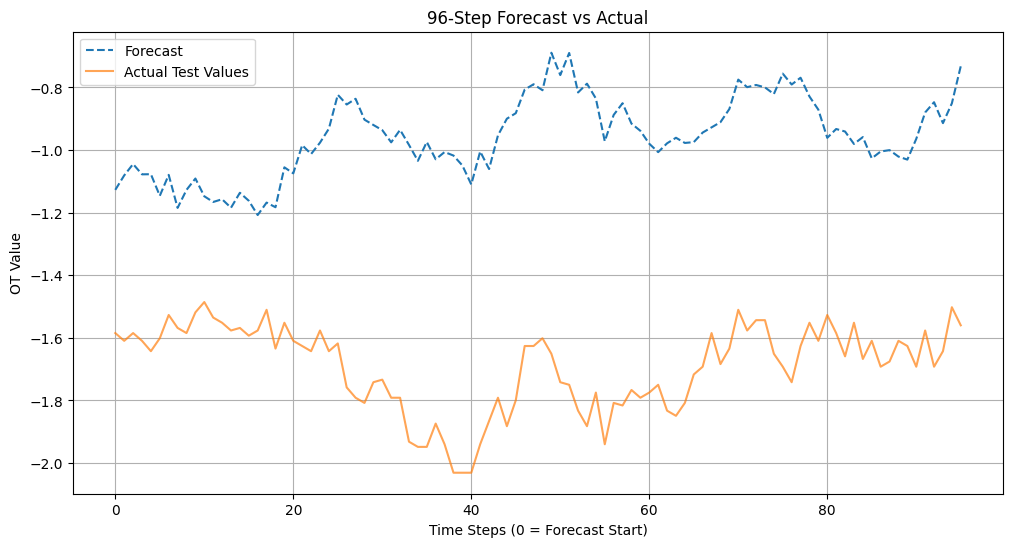

In [ ]:
# change hidden size to 512
SEQ_LENGTH = 96       # Input window size
FORECAST_STEPS = 96   # Number of steps to predict
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LEARNING_RATE = 0.0001
N_EPOCHS = 50
N_EARLY_STOP = 10
train_loader_h1, val_loader_h1, test_loader_h1 = create_dataloaders(train_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS)
model_h1 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h1, train_loader_h1, val_loader_h1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=10, save_path="lstm_weights/exp.pth", criterion=nn.L1Loss())
mse_h1_96_lstm, mae_h1_96_lstm = evaluate_single_forecast(model_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=False, plot_filename="results_images/lstm_h1_96.png")

Epoch 1/50
Train Loss: 0.6368 | Val Loss: 0.8126
Epoch 2/50
Train Loss: 0.3543 | Val Loss: 0.5241
Epoch 3/50
Train Loss: 0.3311 | Val Loss: 0.5675
Epoch 4/50
Train Loss: 0.3269 | Val Loss: 0.5329
Epoch 5/50
Train Loss: 0.3243 | Val Loss: 0.5666
Epoch 6/50
Train Loss: 0.3231 | Val Loss: 0.5487
Epoch 7/50
Train Loss: 0.3201 | Val Loss: 0.5242
Epoch 8/50
Train Loss: 0.3189 | Val Loss: 0.5483
Epoch 9/50
Train Loss: 0.3159 | Val Loss: 0.5832
Epoch 10/50
Train Loss: 0.3127 | Val Loss: 0.5763
Epoch 11/50
Train Loss: 0.3115 | Val Loss: 0.5594
Epoch 12/50
Train Loss: 0.3090 | Val Loss: 0.5698
Early stopping after 12 epochs
Mean Squared Error (MSE): 0.7444
Mean Absolute Error (MAE): 0.8502


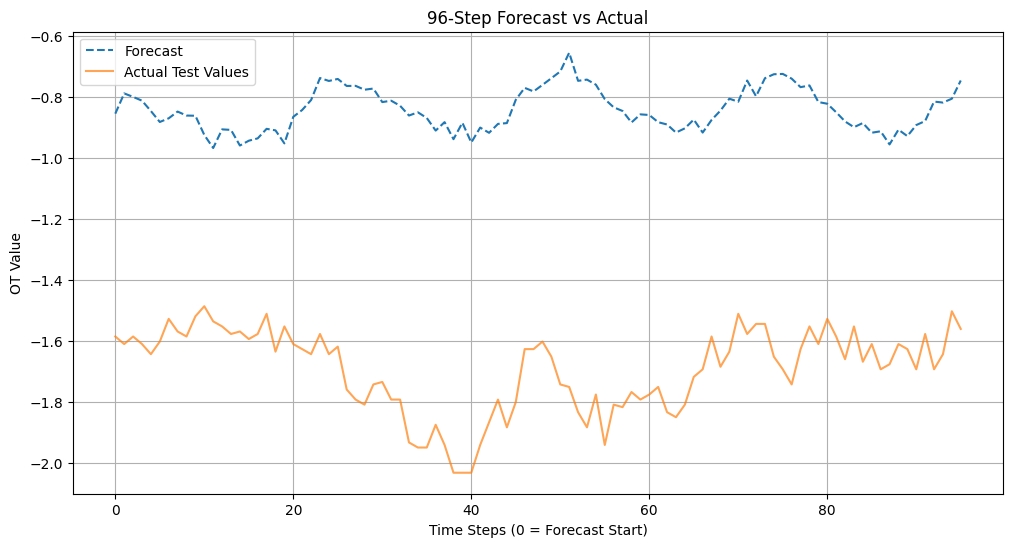

In [ ]:
# change hidden size to 400
SEQ_LENGTH = 96       # Input window size
FORECAST_STEPS = 96   # Number of steps to predict
HIDDEN_SIZE = 400
NUM_LAYERS = 1
LEARNING_RATE = 0.0001
N_EPOCHS = 50
N_EARLY_STOP = 10
train_loader_h1, val_loader_h1, test_loader_h1 = create_dataloaders(train_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS)
model_h1 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h1, train_loader_h1, val_loader_h1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=10, save_path="lstm_weights/exp.pth", criterion=nn.L1Loss())
mse_h1_96_lstm, mae_h1_96_lstm = evaluate_single_forecast(model_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=False, plot_filename="results_images/lstm_h1_96.png")

### 256 seems to be a good hidden_size. Now let's train and save the models

In [7]:
metrics = pd.DataFrame(columns=['model', 'prediction_length', 'dataset', 'mse', 'mae'])
metrics

,model,prediction_length,dataset,mse,mae


##### h1

In [8]:
SEQ_LENGTH = 96       # Input window size
HIDDEN_SIZE = 256
NUM_LAYERS = 1
LEARNING_RATE = 0.0001
N_EPOCHS = 50
N_EARLY_STOP = 10

Epoch 1/50
Train Loss: 0.7030 | Val Loss: 0.8513
Epoch 2/50
Train Loss: 0.4052 | Val Loss: 0.6299
Epoch 3/50
Train Loss: 0.3334 | Val Loss: 0.5488
Epoch 4/50
Train Loss: 0.3281 | Val Loss: 0.5301
Epoch 5/50
Train Loss: 0.3263 | Val Loss: 0.5268
Epoch 6/50
Train Loss: 0.3240 | Val Loss: 0.5505
Epoch 7/50
Train Loss: 0.3220 | Val Loss: 0.5689
Epoch 8/50
Train Loss: 0.3210 | Val Loss: 0.5921
Epoch 9/50
Train Loss: 0.3187 | Val Loss: 0.5578
Epoch 10/50
Train Loss: 0.3160 | Val Loss: 0.5679
Epoch 11/50
Train Loss: 0.3152 | Val Loss: 0.5645
Epoch 12/50
Train Loss: 0.3117 | Val Loss: 0.5812
Epoch 13/50
Train Loss: 0.3097 | Val Loss: 0.5451
Epoch 14/50
Train Loss: 0.3079 | Val Loss: 0.5425
Epoch 15/50
Train Loss: 0.3068 | Val Loss: 0.5987
Early stopping after 15 epochs
Mean Squared Error (MSE): 0.8092
Mean Absolute Error (MAE): 0.8863
Plot saved as results_images/lstm_h1_96.png


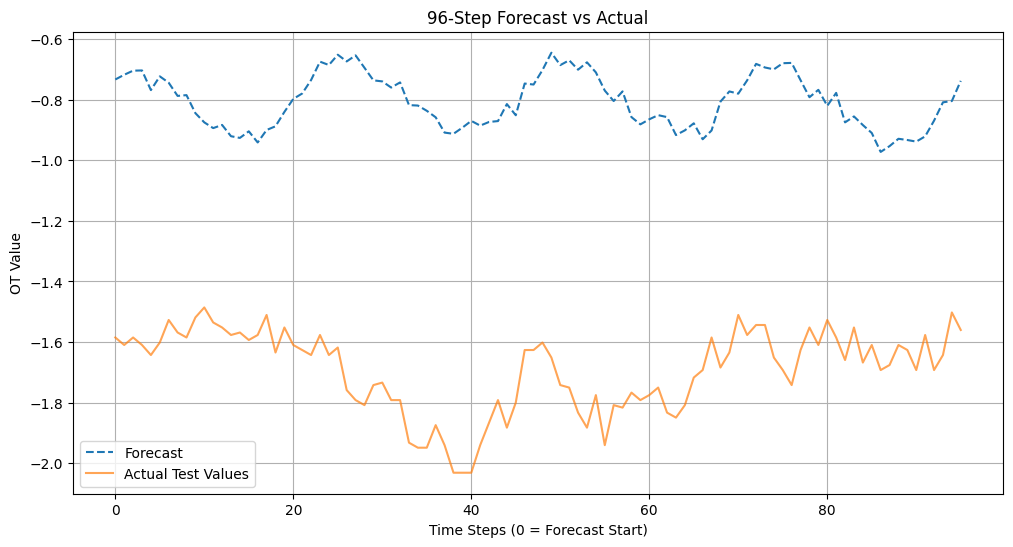

In [9]:
FORECAST_STEPS = 96   # Number of steps to predict
train_loader_h1, val_loader_h1, test_loader_h1 = create_dataloaders(train_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS)
model_h1_96 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h1_96, train_loader_h1, val_loader_h1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_h1_96.pth", criterion=nn.L1Loss())
mse_h1_96_lstm, mae_h1_96_lstm = evaluate_single_forecast(model_h1_96, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_h1_96.png")

In [10]:
new_row = pd.DataFrame([['lstm', 96, 'h1', mse_h1_96_lstm, mae_h1_96_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

/tmp/ipykernel_1367147/3602038877.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, new_row], ignore_index=True)


,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338


Epoch 1/50
Train Loss: 0.7057 | Val Loss: 0.8356
Epoch 2/50
Train Loss: 0.4348 | Val Loss: 0.6364
Epoch 3/50
Train Loss: 0.3502 | Val Loss: 0.6035
Epoch 4/50
Train Loss: 0.3438 | Val Loss: 0.6237
Epoch 5/50
Train Loss: 0.3402 | Val Loss: 0.6392
Epoch 6/50
Train Loss: 0.3385 | Val Loss: 0.6970
Epoch 7/50
Train Loss: 0.3356 | Val Loss: 0.6712
Epoch 8/50
Train Loss: 0.3311 | Val Loss: 0.6569
Epoch 9/50
Train Loss: 0.3276 | Val Loss: 0.7101
Epoch 10/50
Train Loss: 0.3241 | Val Loss: 0.6786
Epoch 11/50
Train Loss: 0.3195 | Val Loss: 0.7470
Epoch 12/50
Train Loss: 0.3160 | Val Loss: 0.7023
Epoch 13/50
Train Loss: 0.3117 | Val Loss: 0.7173
Early stopping after 13 epochs
Mean Squared Error (MSE): 1.1723
Mean Absolute Error (MAE): 1.0702
Plot saved as results_images/lstm_h1_192.png


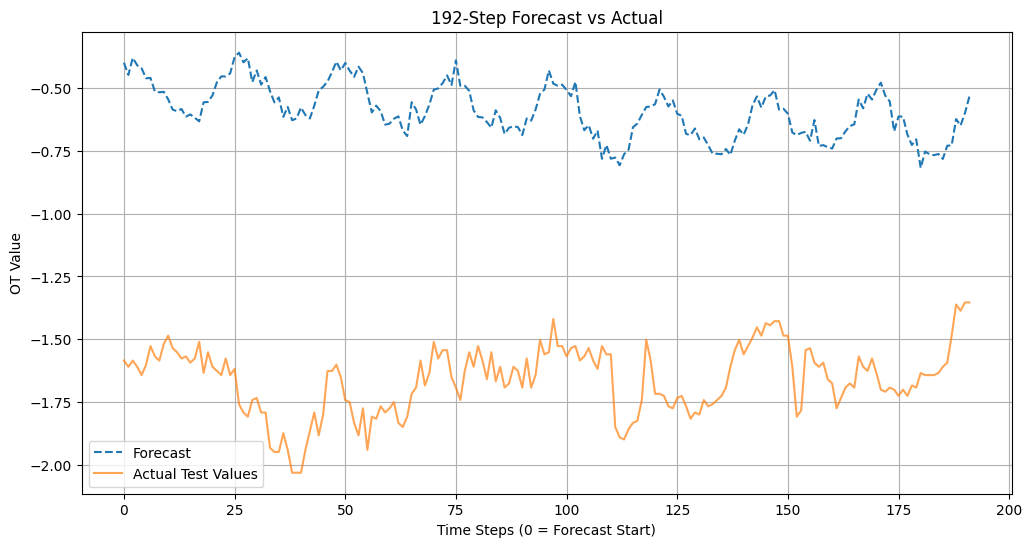

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197


In [11]:
FORECAST_STEPS = 192   # Number of steps to predict
train_loader_h1, val_loader_h1, test_loader_h1 = create_dataloaders(train_h1, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS)
model_h1_192 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h1_192, train_loader_h1, val_loader_h1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_h1_192.pth", criterion=nn.L1Loss())
mse_h1_192_lstm, mae_h1_192_lstm = evaluate_single_forecast(model_h1_192, val_h1, test_h1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_h1_192.png")
new_row = pd.DataFrame([['lstm', 192, 'h1', mse_h1_192_lstm, mae_h1_192_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

**The biggest problem with the predictions is that they are biased (always bigger than the actual values). It can be explained, as the test distribution is different from the train distribution (we talked about this in detail when analyzing Prophet predictions)**

##### h2

Epoch 1/50
Train Loss: 0.7543 | Val Loss: 0.9523
Epoch 2/50
Train Loss: 0.4135 | Val Loss: 0.7503
Epoch 3/50
Train Loss: 0.3797 | Val Loss: 0.7385
Epoch 4/50
Train Loss: 0.3731 | Val Loss: 0.7527
Epoch 5/50
Train Loss: 0.3706 | Val Loss: 0.7289
Epoch 6/50
Train Loss: 0.3675 | Val Loss: 0.7564
Epoch 7/50
Train Loss: 0.3662 | Val Loss: 0.6917
Epoch 8/50
Train Loss: 0.3632 | Val Loss: 0.6950
Epoch 9/50
Train Loss: 0.3609 | Val Loss: 0.6500
Epoch 10/50
Train Loss: 0.3589 | Val Loss: 0.6896
Epoch 11/50
Train Loss: 0.3567 | Val Loss: 0.7041
Epoch 12/50
Train Loss: 0.3545 | Val Loss: 0.6812
Epoch 13/50
Train Loss: 0.3521 | Val Loss: 0.6866
Epoch 14/50
Train Loss: 0.3492 | Val Loss: 0.6613
Epoch 15/50
Train Loss: 0.3487 | Val Loss: 0.7035
Epoch 16/50
Train Loss: 0.3436 | Val Loss: 0.5949
Epoch 17/50
Train Loss: 0.3420 | Val Loss: 0.6135
Epoch 18/50
Train Loss: 0.3443 | Val Loss: 0.6641
Epoch 19/50
Train Loss: 0.3399 | Val Loss: 0.6791
Epoch 20/50
Train Loss: 0.3347 | Val Loss: 0.5863
Epoch 21/

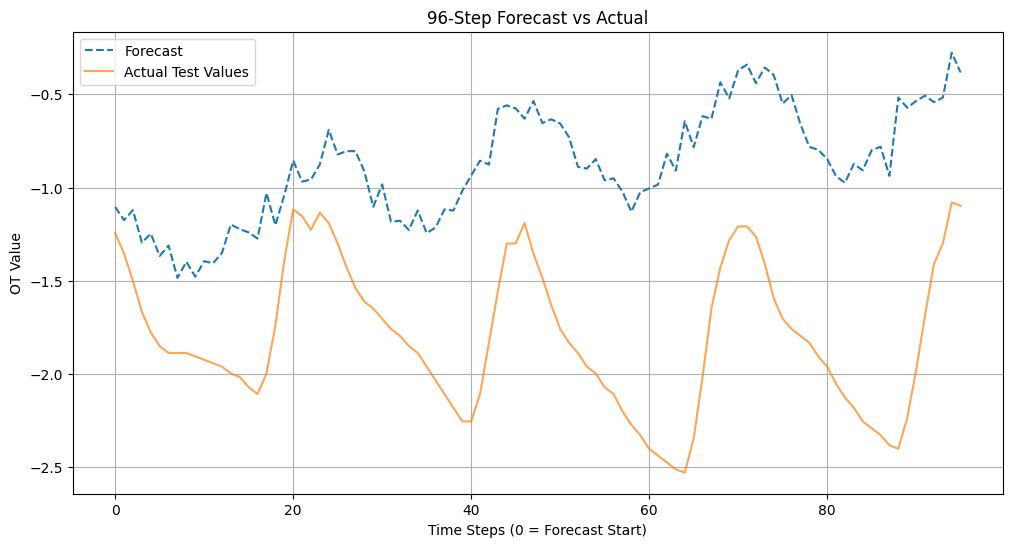

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197
2,lstm,96,h2,0.993186,0.916369


In [12]:
FORECAST_STEPS = 96   # Number of steps to predict
train_loader_h2, val_loader_h2, test_loader_h2 = create_dataloaders(train_h2, val_h2, test_h2, SEQ_LENGTH, FORECAST_STEPS)
model_h2_96 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h2_96, train_loader_h2, val_loader_h2, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_h2_96.pth", criterion=nn.L1Loss())
mse_h2_96_lstm, mae_h2_96_lstm = evaluate_single_forecast(model_h2_96, val_h2, test_h2, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_h2_96.png")
new_row = pd.DataFrame([['lstm', 96, 'h2', mse_h2_96_lstm, mae_h2_96_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

Epoch 1/50
Train Loss: 0.7605 | Val Loss: 0.9736
Epoch 2/50
Train Loss: 0.4337 | Val Loss: 0.8176
Epoch 3/50
Train Loss: 0.3953 | Val Loss: 0.8953
Epoch 4/50
Train Loss: 0.3910 | Val Loss: 0.9587
Epoch 5/50
Train Loss: 0.3900 | Val Loss: 0.9845
Epoch 6/50
Train Loss: 0.3880 | Val Loss: 1.0052
Epoch 7/50
Train Loss: 0.3872 | Val Loss: 1.0282
Epoch 8/50
Train Loss: 0.3857 | Val Loss: 1.0478
Epoch 9/50
Train Loss: 0.3844 | Val Loss: 1.0729
Epoch 10/50
Train Loss: 0.3838 | Val Loss: 1.0749
Epoch 11/50
Train Loss: 0.3805 | Val Loss: 1.0979
Epoch 12/50
Train Loss: 0.3780 | Val Loss: 1.0989
Early stopping after 12 epochs
Mean Squared Error (MSE): 2.7472
Mean Absolute Error (MAE): 1.6115
Plot saved as results_images/lstm_h2_192.png


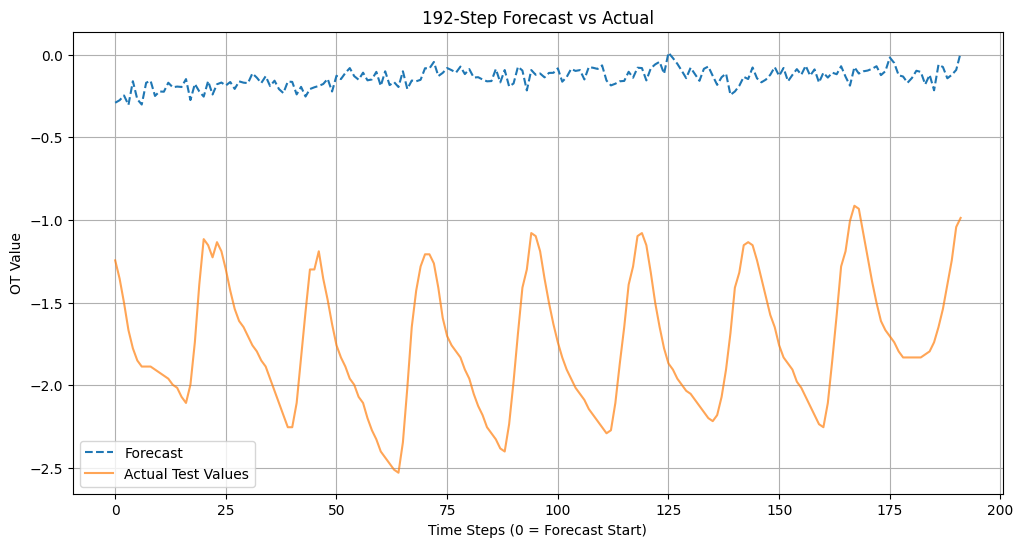

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197
2,lstm,96,h2,0.993186,0.916369
3,lstm,192,h2,2.747193,1.611451


In [13]:
FORECAST_STEPS = 192   # Number of steps to predict
train_loader_h2, val_loader_h2, test_loader_h2 = create_dataloaders(train_h2, val_h2, test_h2, SEQ_LENGTH, FORECAST_STEPS)
model_h2_192 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_h2_192, train_loader_h2, val_loader_h2, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_h2_192.pth", criterion=nn.L1Loss())
mse_h2_192_lstm, mae_h2_192_lstm = evaluate_single_forecast(model_h2_192, val_h2, test_h2, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_h2_192.png")
new_row = pd.DataFrame([['lstm', 192, 'h2', mse_h2_192_lstm, mae_h2_192_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

**We see that the results are still not good, and the training process is very volatile and unstable. Perhaps, the current version of the model is too weak, and we need to train either Seq2Seq LSTM model, or a transformer model. We will do it in the next notebooks**

##### m1

Epoch 1/50
Train Loss: 0.3810 | Val Loss: 0.2738
Epoch 2/50
Train Loss: 0.2405 | Val Loss: 0.2509
Epoch 3/50
Train Loss: 0.2358 | Val Loss: 0.2271
Epoch 4/50
Train Loss: 0.2330 | Val Loss: 0.2623
Epoch 5/50
Train Loss: 0.2301 | Val Loss: 0.2127
Epoch 6/50
Train Loss: 0.2277 | Val Loss: 0.2220
Epoch 7/50
Train Loss: 0.2248 | Val Loss: 0.2433
Epoch 8/50
Train Loss: 0.2208 | Val Loss: 0.2452
Epoch 9/50
Train Loss: 0.2158 | Val Loss: 0.2784
Epoch 10/50
Train Loss: 0.2080 | Val Loss: 0.2952
Epoch 11/50
Train Loss: 0.2025 | Val Loss: 0.3151
Epoch 12/50
Train Loss: 0.1988 | Val Loss: 0.2882
Epoch 13/50
Train Loss: 0.1963 | Val Loss: 0.3487
Epoch 14/50
Train Loss: 0.1936 | Val Loss: 0.3583
Epoch 15/50
Train Loss: 0.1919 | Val Loss: 0.3060
Early stopping after 15 epochs
Mean Squared Error (MSE): 0.2698
Mean Absolute Error (MAE): 0.4859
Plot saved as results_images/lstm_m1_96.png


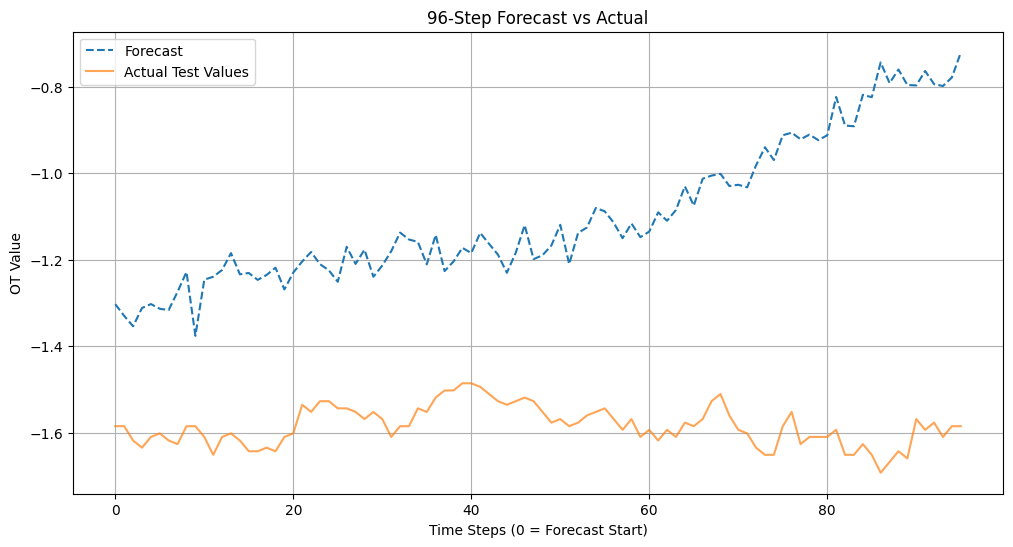

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197
2,lstm,96,h2,0.993186,0.916369
3,lstm,192,h2,2.747193,1.611451
4,lstm,96,m1,0.269840,0.485907


In [14]:
FORECAST_STEPS = 96   # Number of steps to predict
train_loader_m1, val_loader_m1, test_loader_m1 = create_dataloaders(train_m1, val_m1, test_m1, SEQ_LENGTH, FORECAST_STEPS)
model_m1_96 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_m1_96, train_loader_m1, val_loader_m1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_m1_96.pth", criterion=nn.L1Loss())
mse_m1_96_lstm, mae_m1_96_lstm = evaluate_single_forecast(model_m1_96, val_m1, test_m1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_m1_96.png")
new_row = pd.DataFrame([['lstm', 96, 'm1', mse_m1_96_lstm, mae_m1_96_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

Epoch 1/50
Train Loss: 0.4184 | Val Loss: 0.3904
Epoch 2/50
Train Loss: 0.2885 | Val Loss: 0.3806
Epoch 3/50
Train Loss: 0.2835 | Val Loss: 0.3382
Epoch 4/50
Train Loss: 0.2796 | Val Loss: 0.3286
Epoch 5/50
Train Loss: 0.2761 | Val Loss: 0.3262
Epoch 6/50
Train Loss: 0.2720 | Val Loss: 0.3750
Epoch 7/50
Train Loss: 0.2699 | Val Loss: 0.3717
Epoch 8/50
Train Loss: 0.2659 | Val Loss: 0.4029
Epoch 9/50
Train Loss: 0.2606 | Val Loss: 0.3868
Epoch 10/50
Train Loss: 0.2560 | Val Loss: 0.4081
Epoch 11/50
Train Loss: 0.2511 | Val Loss: 0.4342
Epoch 12/50
Train Loss: 0.2467 | Val Loss: 0.4933
Epoch 13/50
Train Loss: 0.2437 | Val Loss: 0.4179
Epoch 14/50
Train Loss: 0.2406 | Val Loss: 0.4610
Epoch 15/50
Train Loss: 0.2381 | Val Loss: 0.4713
Early stopping after 15 epochs
Mean Squared Error (MSE): 0.4718
Mean Absolute Error (MAE): 0.6121
Plot saved as results_images/lstm_m1_192.png


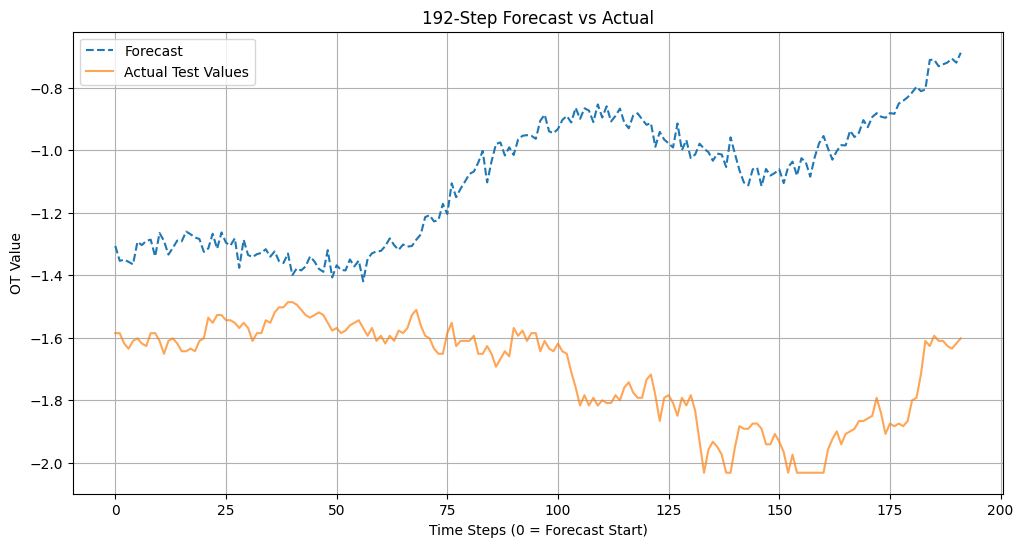

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197
2,lstm,96,h2,0.993186,0.916369
3,lstm,192,h2,2.747193,1.611451
4,lstm,96,m1,0.269840,0.485907
5,lstm,192,m1,0.471839,0.612061


In [15]:
FORECAST_STEPS = 192   # Number of steps to predict
train_loader_m1, val_loader_m1, test_loader_m1 = create_dataloaders(train_m1, val_m1, test_m1, SEQ_LENGTH, FORECAST_STEPS)
model_m1_192 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_m1_192, train_loader_m1, val_loader_m1, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_m1_192.pth", criterion=nn.L1Loss())
mse_m1_192_lstm, mae_m1_192_lstm = evaluate_single_forecast(model_m1_192, val_m1, test_m1, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_m1_192.png")
new_row = pd.DataFrame([['lstm', 192, 'm1', mse_m1_192_lstm, mae_m1_192_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

##### m2

Epoch 1/50
Train Loss: 0.4364 | Val Loss: 0.3496
Epoch 2/50
Train Loss: 0.3101 | Val Loss: 0.3296
Epoch 3/50
Train Loss: 0.3031 | Val Loss: 0.3553
Epoch 4/50
Train Loss: 0.2922 | Val Loss: 0.3711
Epoch 5/50
Train Loss: 0.2755 | Val Loss: 0.3406
Epoch 6/50
Train Loss: 0.2523 | Val Loss: 0.3303
Epoch 7/50
Train Loss: 0.2389 | Val Loss: 0.3387
Epoch 8/50
Train Loss: 0.2298 | Val Loss: 0.3387
Epoch 9/50
Train Loss: 0.2214 | Val Loss: 0.3334
Epoch 10/50
Train Loss: 0.2145 | Val Loss: 0.3174
Epoch 11/50
Train Loss: 0.2090 | Val Loss: 0.3179
Epoch 12/50
Train Loss: 0.2033 | Val Loss: 0.3259
Epoch 13/50
Train Loss: 0.1984 | Val Loss: 0.3252
Epoch 14/50
Train Loss: 0.1938 | Val Loss: 0.3380
Epoch 15/50
Train Loss: 0.1897 | Val Loss: 0.3534
Epoch 16/50
Train Loss: 0.1854 | Val Loss: 0.4051
Epoch 17/50
Train Loss: 0.1830 | Val Loss: 0.3828
Epoch 18/50
Train Loss: 0.1797 | Val Loss: 0.3728
Epoch 19/50
Train Loss: 0.1783 | Val Loss: 0.4074
Epoch 20/50
Train Loss: 0.1759 | Val Loss: 0.3727
Early sto

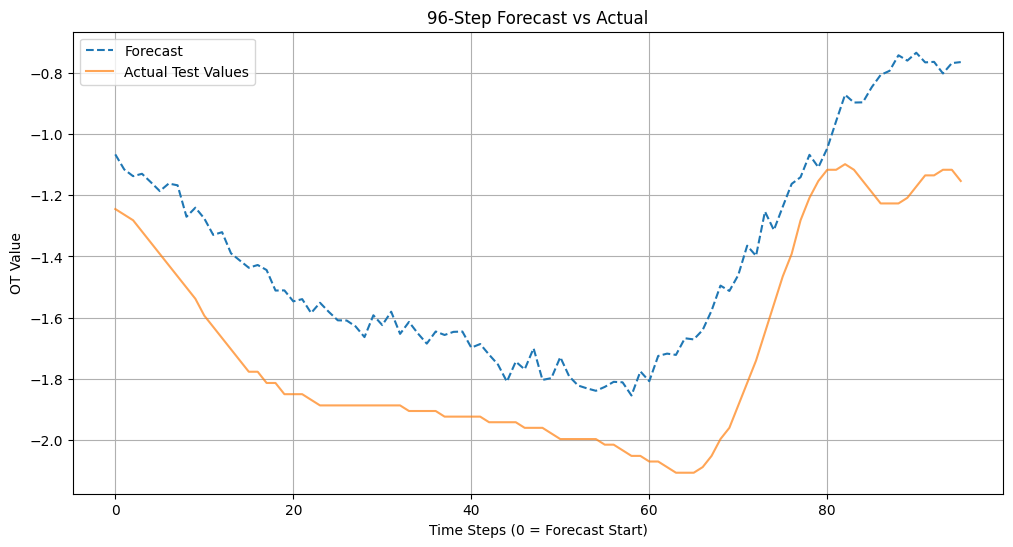

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197
2,lstm,96,h2,0.993186,0.916369
3,lstm,192,h2,2.747193,1.611451
4,lstm,96,m1,0.269840,0.485907
5,lstm,192,m1,0.471839,0.612061
6,lstm,96,m2,0.088945,0.282232


In [16]:
FORECAST_STEPS = 96   # Number of steps to predict
train_loader_m2, val_loader_m2, test_loader_m2 = create_dataloaders(train_m2, val_m2, test_m2, SEQ_LENGTH, FORECAST_STEPS)
model_m2_96 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_m2_96, train_loader_m2, val_loader_m2, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_m2_96.pth", criterion=nn.L1Loss())
mse_m2_96_lstm, mae_m2_96_lstm = evaluate_single_forecast(model_m2_96, val_m2, test_m2, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_m2_96.png")
new_row = pd.DataFrame([['lstm', 96, 'm2', mse_m2_96_lstm, mae_m2_96_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

Epoch 1/50
Train Loss: 0.4655 | Val Loss: 0.4591
Epoch 2/50
Train Loss: 0.3411 | Val Loss: 0.3835
Epoch 3/50
Train Loss: 0.3345 | Val Loss: 0.3960
Epoch 4/50
Train Loss: 0.3262 | Val Loss: 0.4185
Epoch 5/50
Train Loss: 0.3136 | Val Loss: 0.4304
Epoch 6/50
Train Loss: 0.2979 | Val Loss: 0.4515
Epoch 7/50
Train Loss: 0.2826 | Val Loss: 0.4335
Epoch 8/50
Train Loss: 0.2698 | Val Loss: 0.4142
Epoch 9/50
Train Loss: 0.2616 | Val Loss: 0.4117
Epoch 10/50
Train Loss: 0.2557 | Val Loss: 0.4144
Epoch 11/50
Train Loss: 0.2501 | Val Loss: 0.4141
Epoch 12/50
Train Loss: 0.2449 | Val Loss: 0.4161
Early stopping after 12 epochs
Mean Squared Error (MSE): 0.4246
Mean Absolute Error (MAE): 0.5917
Plot saved as results_images/lstm_m2_192.png


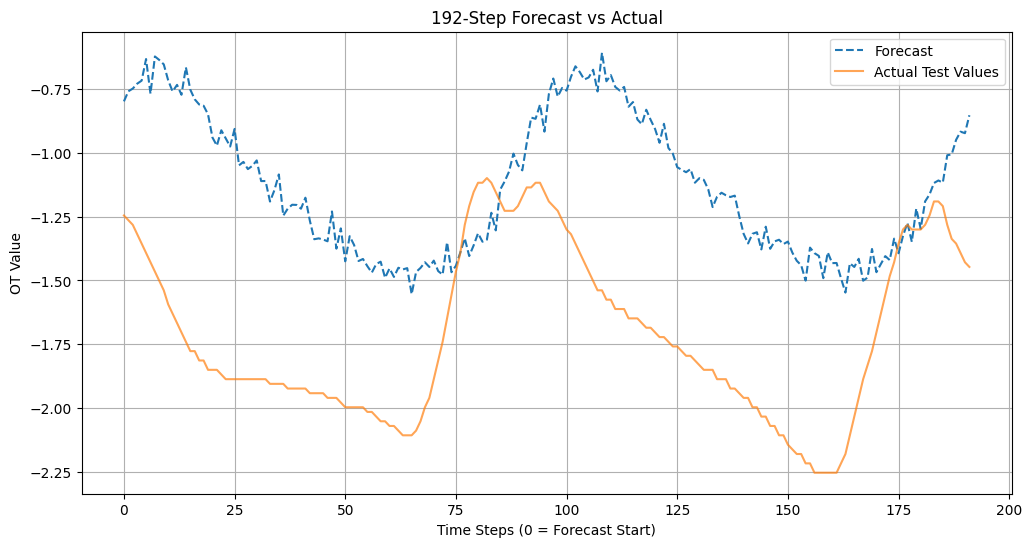

,model,prediction_length,dataset,mse,mae
0,lstm,96,h1,0.809158,0.886338
1,lstm,192,h1,1.172259,1.070197
2,lstm,96,h2,0.993186,0.916369
3,lstm,192,h2,2.747193,1.611451
4,lstm,96,m1,0.269840,0.485907
5,lstm,192,m1,0.471839,0.612061
6,lstm,96,m2,0.088945,0.282232
7,lstm,192,m2,0.424615,0.591656


In [17]:
FORECAST_STEPS = 192   # Number of steps to predict
train_loader_m2, val_loader_m2, test_loader_m2 = create_dataloaders(train_m2, val_m2, test_m2, SEQ_LENGTH, FORECAST_STEPS)
model_m2_192 = LSTMForecaster(input_size=len(features),
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      output_size=FORECAST_STEPS).to(device)
train_lstm(model_m2_192, train_loader_m2, val_loader_m2, device, LEARNING_RATE, N_EPOCHS, N_EARLY_STOP=N_EARLY_STOP, save_path="lstm_weights/best_m2_192.pth", criterion=nn.L1Loss())
mse_m2_192_lstm, mae_m2_192_lstm = evaluate_single_forecast(model_m2_192, val_m2, test_m2, SEQ_LENGTH, FORECAST_STEPS, features, save_plot=True, plot_filename="results_images/lstm_m2_192.png")
new_row = pd.DataFrame([['lstm', 192, 'm2', mse_m2_192_lstm, mae_m2_192_lstm]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

In [22]:
len(train_h2)

10452

In [23]:
len(train_m2)

41808

**So far the results on m2 are the best. The reason is that it has a good data distribution, and the dataset is bigger than h2, therefore, more training data and data for validation**

In [18]:
metrics.to_csv("lstm_metrics.csv", index=False)

### Results

We see that the training process is very unstable. The validation loss should be decreasing smoothly. Instead, it is fluctuating a lot. This is a sign that the model is overfitting to the training data. Perhaps, instead of understanding the patterns in the data, it just tries to memorize the training data. Since the model architecture is very simple, there are not many hyperparameters to tune. The learning rate is very small, and the data does not look very noisy at least in cases of h2 and m2. Therefore, it is possible that the model is not complex enough to capture the patterns in the data. Hence, we will do further experiments with the Seq2Seq model, and the transformer.

Another thing I noticed is that the training process is random. Training a model with the same specifications several times leads to different results. Therefore, it is important to use seeds when initializing the LSTM model. I will take it into account when I will train LSTMs and other neural networks in the future 